In [15]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [9]:
price = pd.read_csv('prepchart.csv')
price.date = pd.to_datetime(price.date, format='%d/%m/%Y')
price.set_index(price.date, drop=True, inplace=True)
price.head(3)

,date,open,high,low,close,adjclose,volume,ratio
date,,,,,,,,
2023-11-01,2023-11-01,288.8,290.0,284.4,287.0,287.0,11006036,0.0962
2023-11-02,2023-11-02,290.0,294.2,286.8,288.6,288.6,10477412,0.0962
2023-11-03,2023-11-03,292.2,304.2,291.4,302.6,302.6,21575201,0.0960


In [10]:
price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 245 entries, 2023-11-01 to 2024-10-30
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      245 non-null    datetime64[ns]
 1   open      245 non-null    float64       
 2   high      245 non-null    float64       
 3   low       245 non-null    float64       
 4   close     245 non-null    float64       
 5   adjclose  245 non-null    float64       
 6   volume    245 non-null    int64         
 7   ratio     245 non-null    float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 17.2 KB


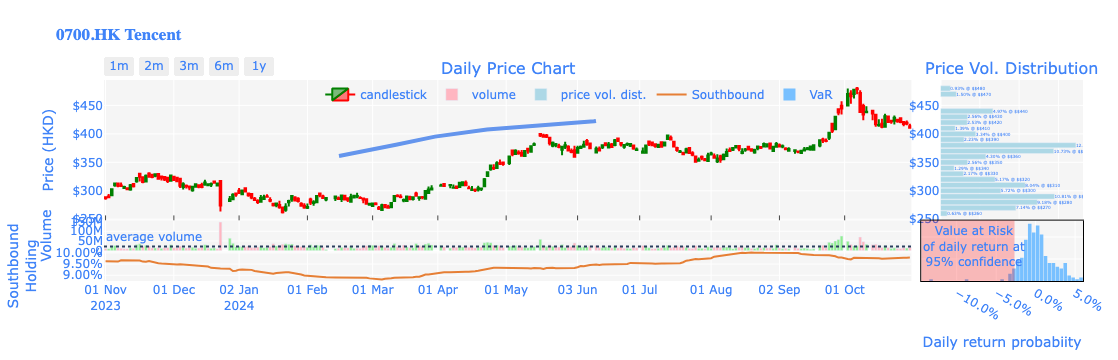

In [14]:
price['log_rtn'] = np.log(price.adjclose/price.adjclose.shift(1))
price['log_rtn'].fillna(0, inplace=True)
price['vol_color'] = np.where(price.close>=price.close.shift(1), 'lightgreen', 'lightpink')

average_vol = price.volume.mean()
VaR = price['log_rtn'].quantile(0.05)   # 5% Probability Loss: - 1.65 x σ
max_drop_ret = price['log_rtn'].min()

price_bins = price.copy()
m = price_bins["close"].mean() 
if m < 0.5 : r_digit = 2
elif m < 15 : r_digit = 1
elif m < 100 : r_digit = 0
else: r_digit = -1

price_bins["close"] = price_bins["close"].round(r_digit) 
price_bins = price_bins.groupby("close", as_index=False)["volume"].sum()
price_bins["percentage"] = price_bins["volume"]*100/price_bins["volume"].sum()

fig = go.Figure()
fig = make_subplots(rows=3, cols=3,
            shared_xaxes=True, shared_yaxes=True,
            column_width=[0.85, 0.01, 0.15,], row_heights=[0.7, 0.15, 0.15],
            horizontal_spacing=0.01, vertical_spacing=0.001,
            subplot_titles=["Daily Price Chart", "","Price Vol. Distribution", "", "", "", "","","" ],
            specs=[ [{"type":"xy"}, {'type':'xy'}, {'type':'xy'} ],     # "secondary_y": True 
                    [{"type":"xy"}, {'type':'xy', "rowspan": 2, "colspan": 2}, None ],  
                    [{"type":"xy"}, None, None],  ],
            )

# Candle
fig.add_trace(go.Candlestick(x=price['date'], open=price['open'], high=price['high'], low=price['low'], close=price['close'], #legendgroup=f'<b>{stock.stockcode} {stock.stockname}</b>',
                                increasing_line_color='green', decreasing_line_color='red', name='candlestick',  ), row=1, col=1,) 

# Volume
fig.add_trace(go.Bar(x=price['date'], y=price['volume'], showlegend=True, marker_color=price["vol_color"], name='volume' ), secondary_y=False, row=2, col=1)
fig.add_hline(y=average_vol, line_dash="dot", annotation_text="average volume", annotation_position="top left", row=2, col=1)

# Price Bin
fig.add_trace(go.Bar(y=price_bins["close"], x=price_bins["volume"], text=price_bins["percentage"], name="price vol. dist.", orientation="h", marker_color="lightblue",
                        texttemplate="%{text:.2f}% @ $%{y}", hoverinfo="x+y" ), row=1, col=3 )  

# Southbound Shareholding
fig.add_trace(go.Scatter(x=price['date'], y=price['ratio'], texttemplate="%{text} %{y:.2}", line=dict(color="#E67F35"), name="Southbound",), col=1, row=3, )

# Histogram
fig.add_trace(go.Histogram(x=price.log_rtn, histnorm='probability', name='VaR',  marker_color='#78C0FF', hoverinfo="x+y"), row=2, col=2 ) #marginal="box"
fig.add_vrect(x0=VaR, x1=max_drop_ret*1.1, annotation_text="Value at Risk<BR>of daily return at<BR>95% confidence", annotation_position="top left", 
            fillcolor="red", opacity=0.25, line_width=0, row=2, col=2 )

# fig.add_trace( go.Scatter(x=price['date'], y=price['close'], line=dict(color="#335DCF"), name="line",), secondary_y=True ) 

fig.update_layout({'plot_bgcolor': 'rgba(245, 245, 245, 10)',
                    'paper_bgcolor': 'rgba(255, 255, 255, 255)',
                    'legend_bgcolor':'rgba(0, 0, 0, 0)' },
                    title=f'<b>0700.HK Tencent</b>',
                    legend=dict(orientation='h', yanchor="top", y=1, xanchor="right", x=0.75),
                    title_font_family="font-semibold",
                    title_font_color="#3F83F8",
                    font_color="#3F83F8",
                    height=800, 
                    modebar_orientation='v',
                    dragmode='drawopenpath',
                    newshape_line_color='cornflowerblue',
                    margin=dict(l=20, r=30, t=80, b=30),
                    bargap=0.1,
                    xaxis5_tickformat = '.1%', # VaR Histogram
                    xaxis5_title_text='Daily return probabiity', # Histogram
                    yaxis6_tickformat = '.2%', # southbound
                    #hovermode='x unified',
                    )
# candle
fig.update_xaxes(showgrid=True, showspikes=True, ticks="inside", dtick="M1", spikemode="across", col=1, row=1)
fig.update_yaxes(title=f"Price (HKD)", showgrid=True, showspikes=True, spikemode="across", tickprefix='$', col=1, row=1)
# volume
fig.update_xaxes(showgrid=True, showspikes=True, spikemode="across", dtick="M1", tickformat="%d %b\n%Y", col=1, row=2)
fig.update_yaxes(title="Volume", showgrid=True, showspikes=True, spikemode="across", col=1, row=2)
# price bin
fig.update_xaxes(showgrid=True, showticklabels=False, col=3, row=1)  # spikemode="across", showticklabels=True, showspikes=True,
fig.update_yaxes(showgrid=True, showticklabels=True, showspikes=True, spikemode="across", tickprefix='$', col=3, row=1 )  # 
# southbound
fig.update_xaxes(showgrid=True, showspikes=True, spikemode="across", dtick="M1", tickformat="%d %b\n%Y", col=1, row=3)
fig.update_yaxes(title="Southbound<BR>Holding", showgrid=True, showspikes=True, spikemode="across", col=1, row=3)

# histogram Value at Risk
fig.update_xaxes(showgrid=True, showspikes=True, linewidth=1, linecolor='black', mirror=True, col=2, row=2)
fig.update_yaxes(showgrid=True, showspikes=True, linecolor='black', mirror=True, showticklabels=False, col=2, row=2) # showticklabels=True, linewidth=1,

fig.update_xaxes(rangeslider_visible=False, col=1, row=1,
                    rangeselector=dict( buttons=list([ dict(count=1, label="1m", step="month", stepmode="backward"),
                                                    dict(count=2, label="2m", step="month", stepmode="backward"),
                                                    dict(count=3, label="3m", step="month", stepmode="backward"),
                                                    dict(count=6, label="6m", step="month", stepmode="backward"),
                                                    dict(count=1, label="1y", step="year", stepmode="backward"),]) ) ,
                                                    rangebreaks=[ dict(bounds=["sat", "mon"]), # hide weekends  (opt out sat 00:00 to mon 00:00 )
                                                                    dict(values=["2024-01-01"])  # hide Christmas and New Year's
                                                                ],       )
fig.add_layout_image(dict(
                    source="https://fintechost.com/static/fth-logo-120.png",
                    xref= "paper",
                    yref= "paper",
                    #sizing= "stretch",
                    x= 0, y= 0,
                    sizex= .1, sizey= .1, opacity= 0.3,
                    xanchor= "left", yanchor= "bottom", layer="below"
                    )  )

config={'modeBarButtonsToAdd': ['drawline', 'drawopenpath', 'drawcircle', 'drawrect', 'eraseshape'], 'displaylogo': False, 
                    'modeBarButtonsToRemove': ['zoom','pan','zoom2d', 'pan2d','zoomIn2d','zoomOut2d','lasso2d','select2d']}

fig.show(config=config)